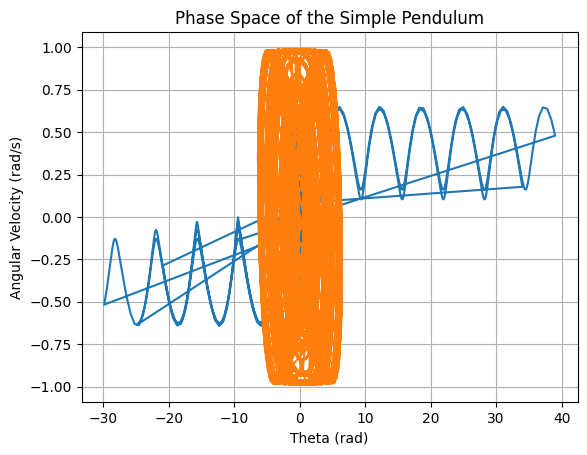

In [2]:
from sklearn.metrics.pairwise import rbf_kernel

import numpy as np
from scipy.integrate import odeint

# Simple pendulum parameters
g = 9.81  # gravitational constant
l = 1.0   # length of pendulum

# Define the simple pendulum ODEs
def pendulum_ode(state, t):
    theta, v = state
    dtheta_dt = v
    dv_dt = -(g / l) * np.sin(theta)
    return [dtheta_dt, dv_dt]

# Generate data for training (simulate multiple trajectories)
def generate_pendulum_data(num_trajectories, t_max, num_points):
    t = np.linspace(0, t_max, num_points)  # time array
    X_train = []
    Y_train = []
    
    # Simulate pendulum for different initial conditions
    for i in range(num_trajectories):
        theta0 = np.random.uniform(-np.pi, np.pi)  # random initial angle
        v0 = np.random.uniform(-2, 2)  # random initial velocity
        state0 = [theta0, v0]
        trajectory = odeint(pendulum_ode, state0, t)  # simulate trajectory
        
        X_train.append(trajectory[:-1])  # current states
        Y_train.append(trajectory[1:] - trajectory[:-1])  # state derivatives (velocities)
    
    X_train = np.vstack(X_train)
    Y_train = np.vstack(Y_train)
    
    return X_train, Y_train, t

# Generate training data
X_train, Y_train, t = generate_pendulum_data(num_trajectories=50, t_max=10, num_points=100)



# Define the Gaussian kernel function
def gaussian_kernel(X, Y, sigma):
    return rbf_kernel(X, Y, gamma=1/(2 * sigma ** 2))

# Solve the regularized least-squares problem to learn the dynamics
def learn_pendulum_dynamics(X_train, Y_train, sigma, lambd):
    N = X_train.shape[0]
    
    # Compute the kernel matrix
    K = gaussian_kernel(X_train, X_train, sigma)
    
    # Solve the system (K + N * lambda * I) * A = Y_train
    A = np.linalg.solve(K + N * lambd * np.eye(N), Y_train)
    
    return A

# Set hyperparameters for the Gaussian kernel
sigma = 1.0  # Kernel width
lambd = 0.1  # Regularization parameter

# Learn the dynamics
A = learn_pendulum_dynamics(X_train, Y_train, sigma, lambd)

# Predict the dynamics at new points
def predict_pendulum_dynamics(X_new, X_train, A, sigma):
    K_new = gaussian_kernel(X_new, X_train, sigma)
    return K_new.dot(A)

# Generate new points for testing (e.g., a phase space grid)
theta_vals = np.linspace(-np.pi, np.pi, 100)
v_vals = np.linspace(-2, 2, 100)
Theta, V = np.meshgrid(theta_vals, v_vals)
X_test = np.column_stack([Theta.ravel(), V.ravel()])

# Predict the dynamics (velocity and acceleration)
Y_pred = predict_pendulum_dynamics(X_test, X_train, A, sigma)

import matplotlib.pyplot as plt

# Reshape predicted velocities for phase plot
V_pred = Y_pred[:, 0].reshape(Theta.shape)
A_pred = Y_pred[:, 1].reshape(Theta.shape)

#plt.plot(V_pred, A_pred, 'o')
plt.title("Phase Space of the Simple Pendulum")
plt.xlabel("Theta (rad)")
plt.ylabel("Angular Velocity (rad/s)")
plt.plot(X_train, Y_train)
plt.grid(True)
plt.show()
